In [3]:
import sys
sys.path.append("../")
import matplotlib.pyplot as plt

In [4]:
import scanpy as sc
import pandas as pd
import numpy as np

# Load Observed Data

In [5]:
Xad = sc.read_h5ad("../../Data/echidna3/Tumor2_X.h5ad")
Xad

AnnData object with n_obs × n_vars = 2337 × 27762
    obs: 'celltypes', 'celltypes_RNA', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_original_total_counts', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'celltypes_RNA_colors', 'celltypes_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
Wdf = pd.read_csv("../../Data/echidna3/Tumor2_W.csv")
Wdf.set_index("Unnamed: 0", inplace=True)
Wdf.index.name = "gene"
Wdf.head()

,0
gene,
A3GALT2,10.522400
AADACL3,12.252164
AADACL4,12.252164
ABCA4,11.080183
ABCB10,11.838389


In [7]:
DNA = pd.read_csv("../../Data/echidna3/DNA_bin_counts_matrix.txt", sep='\t')

In [8]:
from echidna.utils import *

/Users/mingxuanzhang/anaconda3/envs/work3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
X_obs, W_obs, z_obs, pi_obs = prepare_input(Xad, Wdf, sample_name=None, 
                                            timepoints=['st'], n_subsamples=3000, device="cpu")
print(X_obs.shape)
print(W_obs.shape)
print(z_obs.shape)
print(pi_obs.shape)

torch.Size([2337, 27762])
torch.Size([27762])
torch.Size([2337])
torch.Size([10])


# Fit the model and simulate data

In [10]:
from echidna.model import Echidna
from echidna.train import train_Echidna
from echidna.utils import ModelConfig
from echidna.params import *
from echidna.eval import *

In [11]:
config = ModelConfig()
config.num_cells = X_obs.shape[1]
config.num_genes = X_obs.shape[-1]
config.num_clusters = pi_obs.shape[0]
config.q_corr_init = 0.1
config.q_shape_rate_scaler = 10.0
config.eta_mean_init = 11.0
config.lkj_concentration = 0.5

In [12]:
echidna = Echidna(config, mode='ST', device='cpu')
echidna, losses = train_Echidna(echidna, X_obs, W_obs, pi_obs, z_obs, lr=0.1, n_epochs=1000)

100%|██████████| 1000/1000 [06:51<00:00,  2.43it/s]


In [13]:
eta_ground_truth = eta_posterior_estimates(echidna, X_obs, W_obs, pi_obs, z_obs, num_samples=1000)
c_ground_truth = c_posterior_estimates(eta=eta_ground_truth, mt=False)
cov_ground_truth = cov_posterior_estimate(inverse_gamma=True)

In [14]:
print(eta_ground_truth.shape)
print(c_ground_truth.shape)
print(cov_ground_truth.shape)

torch.Size([10, 27762])
torch.Size([10, 27762])
(10, 10)


In [15]:
library_size = X_obs.sum(-1, keepdim=True) * 1e-5
X_simulated = sample_X(X_obs.numpy(), c_ground_truth, eta_ground_truth, z_obs.numpy(), library_size)
X_simulated.shape

(2337, 27762)

In [16]:
W_simulated = sample_W(pi=pi_obs, eta=eta_ground_truth)
W_simulated.shape

(27762,)

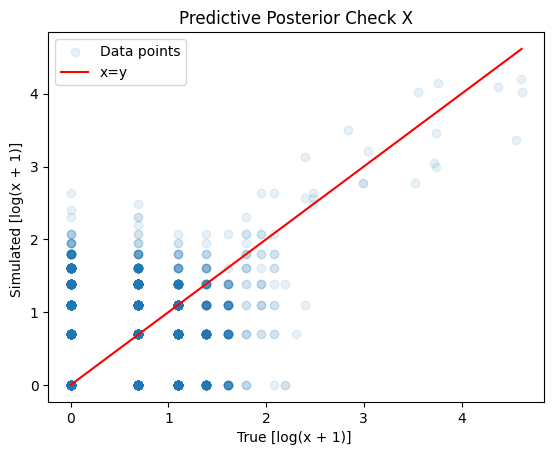

In [18]:
pred_posterior_check(X_simulated, X_obs.numpy(), name="X", log_scale=True, R_val=False)

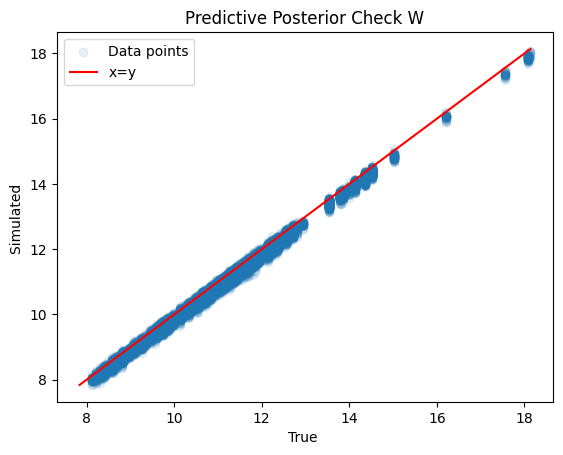

In [20]:
pred_posterior_check(W_simulated, W_obs.numpy(), name="W", log_scale=False, R_val=False)

In [22]:
import seaborn as sns

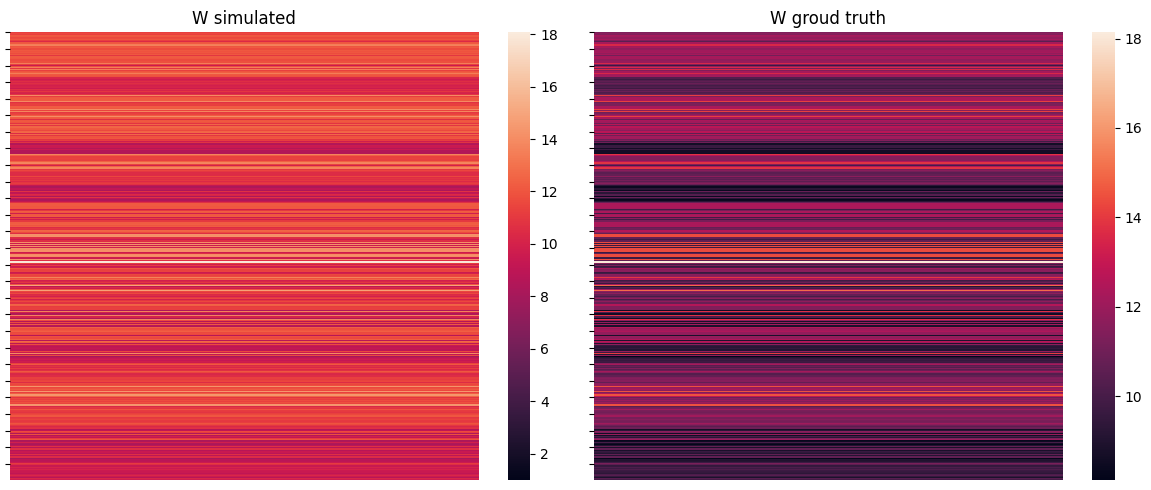

In [24]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first heatmap
sns.heatmap(W_simulated.reshape(-1, 1), ax=axes[0], vmin=1)
axes[0].set_title('W simulated')
axes[0].set_xticks([])
axes[0].set_yticklabels([])

# Plot the second heatmap
sns.heatmap(W_obs.numpy().reshape(-1, 1), ax=axes[1])
axes[1].set_title("W groud truth")
axes[1].set_xticks([])
axes[1].set_yticklabels([])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Fit with simulated data

In [25]:
echidna = Echidna(config, mode='ST', device='cpu')
echidna, losses = train_Echidna(echidna, torch.tensor(X_simulated), torch.tensor(W_simulated), pi_obs, z_obs, lr=0.1, n_epochs=1000)

 87%|████████▋ | 866/1000 [03:25<00:31,  4.26it/s]

In [29]:
eta_learned = eta_posterior_estimates(echidna, torch.tensor(X_simulated), torch.tensor(W_simulated), pi_obs, z_obs, num_samples=10000)
c_learned = c_posterior_estimates(eta=eta_ground_truth, mt=False)
cov_learned = cov_posterior_estimate(inverse_gamma=True)

In [ ]:
pred_posterior_check(np.array(eta_learned), np.array(eta_ground_truth), 
                     name='eta', log_scale=False, R_val=True, equal_line=False, save=False, 
                     title="Refitted vs. Original", xlabname="Original ", ylabname="Refitted ")

In [ ]:
pred_posterior_check(np.array(c_learned), np.array(c_ground_truth), 
                     name='C', log_scale=False, R_val=True, equal_line=False, save=False, 
                     title="Refitted vs. Original", xlabname="Original ", ylabname="Refitted ")

In [ ]:
compare_covariance_matrix(cov_learned, cov_ground_truth)